* This script is used for the online course "资金流入流出" in Tianchi platform
* 原出处Datawhale第十六期组队学习

# 建模预测

In [83]:
import pandas as pd
import sklearn as skr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from typing import *
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1024)

labels = ['total_purchase_amt', 'total_redeem_amt']

In [84]:
# 设置数据集路径

dataset_path = '../../data/Datawhale-Tianchi-DM_FundFlow/data_origin/'
data_feature_path = '../../data/Datawhale-Tianchi-DM_FundFlow/data_feature/'
data_submit_path = '../../data/Datawhale-Tianchi-DM_FundFlow/data_submit/'

In [85]:
# 分割数据集

def split_data_underline(data: pd.DataFrame)->pd.DataFrame:
    trainset = data[(datetime.datetime(2014,4,1) <= data['date']) & (data['date'] < datetime.datetime(2014,8,1))]
    testset = data[(datetime.datetime(2014,8,1) <= data['date']) & (data['date'] < datetime.datetime(2014,9,1))]
    return trainset, testset

def split_data_online(data: pd.DataFrame)->pd.DataFrame:
    trainset = data[(datetime.datetime(2014,4,1) <= data['date']) & (data['date'] < datetime.datetime(2014,9,1))]
    testset = data[(datetime.datetime(2014,9,1) <= data['date']) & (data['date'] < datetime.datetime(2014,10,1))]
    return trainset, testset

In [86]:
# 定义评价函数

def AE(y: Iterable, yhat: Iterable)->Iterable:
    return np.abs(y - yhat) / np.abs(y)

def total_AE(purchasehat: Iterable, redeemhat: Iterable, purchase: Iterable, redeem: Iterable, h: int = 0.3)->Iterable:
    return sum(map(lambda x : np.exp(-x/h)*10, AE(purchase, purchasehat))) * 0.45 + sum(map(lambda x : np.exp(-x/h)*10, AE(redeem, redeemhat))) * 0.55

In [87]:
# 在不同的时间段对模型进行验证

def week_evalution_single(data: pd.DataFrame, model: object, types: str)->pd.DataFrame:
    results = []
    a_month = relativedelta(months=1)
    for i in [datetime.datetime(2014, 8, 1), datetime.datetime(2014, 7, 25), datetime.datetime(2014, 7, 18), datetime.datetime(2014, 7, 11), 
          datetime.datetime(2014, 7, 4), datetime.datetime(2014, 6, 27), datetime.datetime(2014, 6,20)]:
        trainset = data[(i - 4 * a_month <= data['date']) & (data['date'] < i)]
        testset = data[(i <= data['date']) & (data['date'] < i + a_month)]
        if len(testset) == 0 or len(trainset) == 0:
            i = datetime.datetime(2014, 4, 20)
            trainset = data[(i - 4 * a_month <= data['date']) & (data['date'] < i)]
            testset = data[(i <= data['date']) & (data['date'] < datetime.datetime(2014, 9, 1))]
        feature = [x for x in trainset.columns if x not in ['total_purchase_amt','total_redeem_amt','date']]
        
        model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
        result_lr = model.predict(testset[feature])
        
        h = 0.3
        results.append(sum(AE(testset['total_' + types + '_amt'], result_lr).apply(lambda x : np.exp(-x/h))*10))
    return pd.DataFrame(results)

In [88]:
# 输出评级表格

def draw_eva_table(df: pd.DataFrame)->pd.DataFrame:
    rest = df.copy()
    rest['interval'] = [datetime.datetime(2014, 8, 1), datetime.datetime(2014, 7, 25), datetime.datetime(2014, 7, 18), datetime.datetime(2014, 7, 11), 
          datetime.datetime(2014, 7, 4), datetime.datetime(2014, 6, 27), datetime.datetime(2014, 6,20)]
    return rest

In [89]:
# 对生成结果进行可视化

def visual(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame)->None:
    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'], result_purchase_lr, label='predicted_purchase')
    plt.plot(testset['date'], testset['total_purchase_amt'], label='real_redeem')

    plt.legend(loc='best')
    plt.title("The distribution of real and predict purchase")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()
    fig = plt.figure(figsize=(10,4))
    sns.barplot(testset['date'].dt.day ,result_purchase_lr - testset['total_purchase_amt'])

    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'], result_redeem_lr, label='predicted_redeem')
    plt.plot(testset['date'], testset['total_redeem_amt'], label='real_redeem')

    plt.legend(loc='best')
    plt.title("The distribution of real and predict redeem")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()
    fig = plt.figure(figsize=(10,4))
    sns.barplot(testset['date'].dt.day ,result_redeem_lr - testset['total_redeem_amt'])

In [90]:
# 定义提取线下最好效果特征的函数

def feature_extract(data: pd.DataFrame, model: object, types: str)->Tuple[List[str], List[float]]:
    features = [x for x in data.columns if x not in labels + ['date']]
    random.shuffle(features)
    results = []
    score = -1
    for i in features:
        score_update = np.mean(week_evalution_single(data[results + [i] + labels + ['date']], model, types))
        if score_update > score:
            score = score_update
            results.append(i)
    return results, score
    
def robust_feature_extract(data: pd.DataFrame, model: object, types: str):
    results = []
    score = -1
    for i in range(10):
        results_update, score_update = feature_extract(data, model, types)
        if score_update > score:
            score = score_update
            results = results_update
        print(results_update, score_update)
    return results

In [91]:
# 定义AIC,BIC评价指标

def AIC(L: Iterable, delta: float, n_features: int):
    return L * np.log10(delta) + 2 * (n_features + 1)
def AIC(L: Iterable, delta: float, n_features: int):
    return L * np.log10(delta) + (n_features + 1) * np.log10(L)

In [92]:
# 使用AIC指标融合模型

def feature_extract_AIC(data: pd.DataFrame, model: object, types: str)->Tuple[List[str], float]:
    features = [x for x in data.columns if x not in labels + ['date']]
    random.shuffle(features)
    results = []
    test_score = 1e9
    train_score = 0
    for i in features:
        test_score_update = np.mean(week_evalution_single(data[results + [i] + labels + ['date']], model, types)[0])
        if test_score_update < test_score:
            test_score = test_score_update
            results.append(i)
            
    trainset, testset = split_data_underline(data)
    feature = results
    model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
    train_result_lr = model.predict(trainset[feature])
    delta = mean_squared_error(train_result_lr, trainset['total_' + types + '_amt'])
    #delta = np.sum(AE(trainset['total_' + types + '_amt'], train_result_lr).apply(lambda x : np.exp(-x/0.1))*10)
    return results, AIC(len(trainset), delta, len(feature))

def multi_model(data: pd.DataFrame, model: object, types: str)->Tuple[List[List[str]], float]:
    features = []
    weights = []
    for i in range(100):
        results_update, score_update = feature_extract_AIC(data, model, types)
        features.append(results_update)
        weights.append(score_update)
    avg = np.mean(weights)
    weights = [x - avg for x in weights]
    weights = [np.power((-1 * x / 2), 10) for x in weights]
    summ = np.sum(weights)
    weights = [x / summ for x in weights]
    return features, weights

In [93]:
# 生成线上结果

def generate_online_result(df: pd.DataFrame, feature: Iterable, model = LinearRegression(), target:str = 'total_purchase_amt')->Iterable:
    trainset, testset = split_data_online(df)
    model.fit(X=trainset[feature], y=trainset[target])
    result_purchase_lr = model.predict(testset[feature])
    return result_purchase_lr

In [94]:
def generate_under_result(df: pd.DataFrame, feature: Iterable, model = LinearRegression(), target:str = 'total_purchase_amt')->Iterable:
    trainset, testset = split_data_underline(df)
    model.fit(X=trainset[feature], y=trainset[target])
    result_purchase_lr = model.predict(testset[feature])
    return result_purchase_lr

In [95]:
# 生成线上提交的格式

def normalize_upload_file(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame)->pd.DataFrame:
    testset['total_purchase_amt'] = result_purchase_lr
    testset['total_redeem_amt'] = result_redeem_lr
    online_upload = testset[['date','total_purchase_amt','total_redeem_amt']]
    online_upload['date'] = online_upload['date'].astype(str)
    online_upload['date'] = online_upload['date'].str.replace('-','')
    return online_upload

In [96]:
# 线上结果可视化

def draw_result(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame):
    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'].dt.day, result_purchase_lr, label='online_purchase')
    plt.plot(testset['date'].dt.day, result_redeem_lr, label='online_redeem')

    plt.legend(loc='best')
    plt.title("The predict values")
    plt.xlabel("Time")
    plt.ylabel("Amount")

In [97]:
# 重载DataFrame加法

def add_two_df(df1, df2, features = None, left_a = 0.45, right_a = 0.55):
    data = df1.copy()
    if not features:
        features = [x for x in data.columns if x != 'interval']
    for i in features:
        data[i] = (data[i] * left_a + df2[i] * right_a)
    return data

In [98]:
# 重载DataFrame乘法

def scale_df(df1, features = None, eta = 1):
    data = df1.copy()
    if not features:
        features = [x for x in data.columns if x != 'interval']
    for i in features:
        data[i] *= eta
    return data

# 建模测试

## 一、仅使用IS特征

In [99]:
data = pd.read_csv(data_feature_path + '0615_residual_purchase_origined.csv')
data['date'] = pd.to_datetime(data['date'])

In [100]:
data.head()

,total_purchase_amt,total_redeem_amt,dis_to_nowork,dis_to_work,dis_from_work,purchase_weekdayrate,redeem_dayrate,weekday_onehot_5,weekday_onehot_6,dis_from_nowork,...,weekday_onehot_3,is_lastday_of_holiday,is_firstday_of_holiday,weekday_onehot_4,is_worked_yestday,is_second_week,is_third_week,dis_from_startofmonth,dis_from_holiday,date
0,398884905.0,423852634.0,5,0,0,1.125999,1.013956,0.0,0.0,1,...,0.0,0,0,0.0,0,1,0,10,1,2014-03-31
1,453320585.0,277429358.0,4,0,0,1.125999,1.013956,0.0,0.0,2,...,0.0,0,0,0.0,0,1,0,1,2,2014-04-01
2,355347118.0,272612066.0,3,0,0,1.125999,1.013956,0.0,0.0,3,...,0.0,0,0,0.0,1,1,0,2,3,2014-04-02
3,363877120.0,266605457.0,2,0,0,1.125999,1.013956,0.0,0.0,4,...,1.0,0,0,0.0,1,1,0,3,4,2014-04-03
4,251895894.0,200192637.0,1,0,0,1.125999,1.013956,0.0,0.0,5,...,0.0,0,0,1.0,1,1,0,4,5,2014-04-04


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_purchase_amt      154 non-null    float64       
 1   total_redeem_amt        154 non-null    float64       
 2   dis_to_nowork           198 non-null    int64         
 3   dis_to_work             198 non-null    int64         
 4   dis_from_work           198 non-null    int64         
 5   purchase_weekdayrate    198 non-null    float64       
 6   redeem_dayrate          198 non-null    float64       
 7   weekday_onehot_5        198 non-null    float64       
 8   weekday_onehot_6        198 non-null    float64       
 9   dis_from_nowork         198 non-null    int64         
 10  is_holiday              198 non-null    int64         
 11  weekday_onehot_1        198 non-null    float64       
 12  weekday_onehot_2        198 non-null    float64   

In [102]:
trainset, testset = split_data_underline(data)
result_purchase_lr = generate_under_result(data, [x for x in data.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], target='total_purchase_amt')
result_redeem_lr = generate_under_result(data, [x for x in data.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], target='total_redeem_amt')

### 在八月份预测结果

In [103]:
total_AE(result_purchase_lr, result_redeem_lr, testset['total_purchase_amt'], testset['total_redeem_amt'])

182.93817684517143

### 滑窗测试结果

In [104]:
draw_eva_table(week_evalution_single(data, model=LinearRegression(), types = 'purchase'))

,0,interval
0,201.600564,2014-08-01
1,175.984864,2014-07-25
2,171.765530,2014-07-18
3,177.250268,2014-07-11
4,166.640034,2014-07-04
5,182.064179,2014-06-27
6,173.700959,2014-06-20


In [105]:
draw_eva_table(week_evalution_single(data, LinearRegression(), 'redeem'))

,0,interval
0,167.668951,2014-08-01
1,160.703900,2014-07-25
2,196.225281,2014-07-18
3,191.747000,2014-07-11
4,193.872228,2014-07-04
5,194.245124,2014-06-27
6,176.023751,2014-06-20


### 八月份预测图与真实图

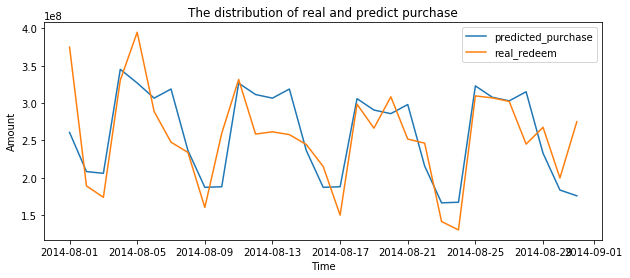

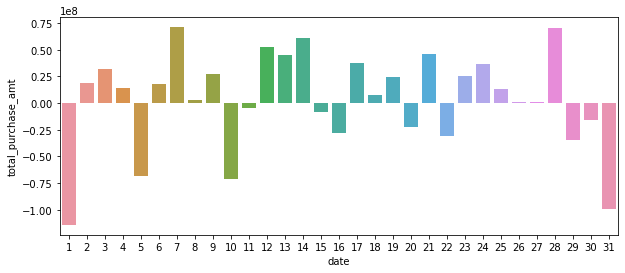

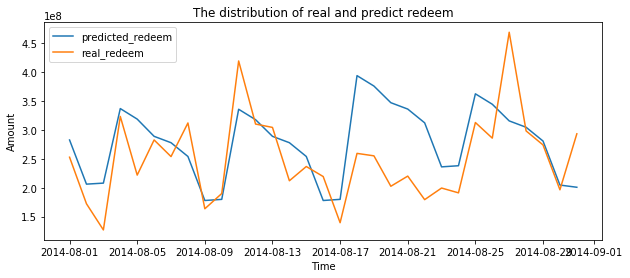

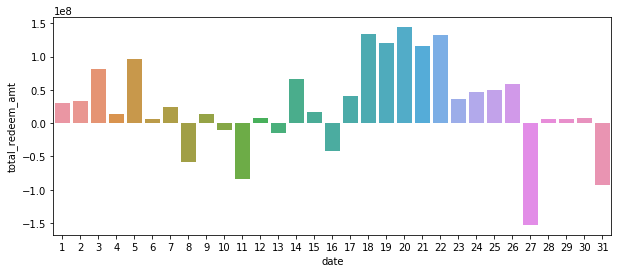

In [106]:
visual(result_purchase_lr, result_redeem_lr, testset)

In [107]:
result_purchase_lr = generate_online_result(data, [x for x in trainset.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data, [x for x in trainset.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_redeem_amt')

### 九月份预测效果图(线性)

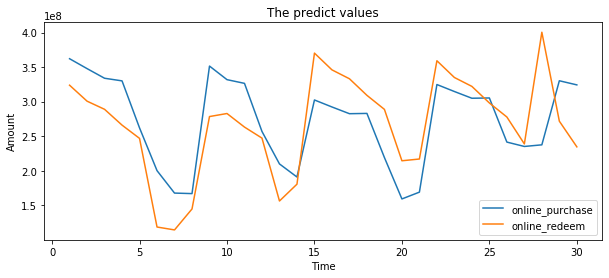

In [108]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [109]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv(data_submit_path + '20190612_only_is-nb6.csv',index=False,header=None)

线上预测效果：

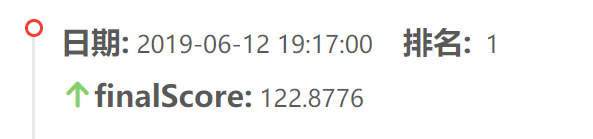

## 二、多模型对比

In [110]:
def multi_model_eva(data, types:str = 'purchase'):
    results = pd.DataFrame()
    for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
        if results.empty:
            results = draw_eva_table(week_evalution_single(data, model, types)).rename(columns={0: repr(model).split('(')[0]})
        else:
            results = pd.merge(results, \
                               draw_eva_table(week_evalution_single(data, model, types)).rename(columns={0: repr(model).split('(')[0]}), on='interval')
    results = results[['interval'] + [x for x in results.columns if x != 'interval']]
    return results

In [111]:
add_two_df(multi_model_eva(data, 'purchase'), multi_model_eva(data, 'redeem'))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,182.938177,165.711752,177.152171,171.573022,173.057952,170.655095
1,2014-07-25,167.580334,155.868933,171.976994,164.268817,165.132004,158.665215
2,2014-07-18,185.218393,184.065869,186.327747,177.931546,186.724096,178.284176
3,2014-07-11,185.223471,177.899716,177.714086,173.885325,168.258463,170.143165
4,2014-07-04,181.617741,156.163570,171.896185,163.990161,174.079060,159.678860
5,2014-06-27,188.763699,172.671793,184.612363,181.629431,158.927530,172.982609
6,2014-06-20,174.978495,164.106465,174.512152,174.882134,162.968698,169.889808


## 三、劣汰后特征对比

In [112]:
data_purchase = pd.read_csv(data_feature_path + 'purchase_feature_droped_0614.csv')
data_purchase['date'] = pd.to_datetime(data_purchase['date'])

In [113]:
# data_redeem = pd.read_csv('Feature/redeem_feature_droped_0614.csv')
data_redeem = pd.read_csv(data_feature_path + 'purchase_feature_droped_0614.csv')
data_redeem['date'] = pd.to_datetime(data_redeem['date'])

In [114]:
trainset_purchase, testset_purchase = split_data_underline(data_purchase)
result_purchase_lr = generate_under_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')

In [115]:
trainset_redeem, testset_redeem = split_data_underline(data_redeem)
result_redeem_lr = generate_under_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')

In [116]:
total_AE(result_purchase_lr, result_redeem_lr, testset_purchase['total_purchase_amt'], testset_redeem['total_redeem_amt'])

174.06417080343275

In [117]:
add_two_df(multi_model_eva(data_purchase, 'purchase'), multi_model_eva(data_redeem, 'redeem'))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,174.064171,157.522364,176.079471,168.401441,173.442169,160.549147
1,2014-07-25,161.286057,156.978725,172.279984,164.083707,163.299632,163.178648
2,2014-07-18,181.974142,173.995753,186.928883,179.939926,182.549418,179.082897
3,2014-07-11,179.999731,156.021611,172.411904,173.283666,175.932991,176.611508
4,2014-07-04,171.860441,156.023362,164.194420,165.886632,166.413613,154.838255
5,2014-06-27,180.758808,157.974076,181.714403,181.070151,173.296401,172.190603
6,2014-06-20,169.800762,173.825244,177.539824,176.044822,159.889817,163.660270


### 八月份预测效果(线性)

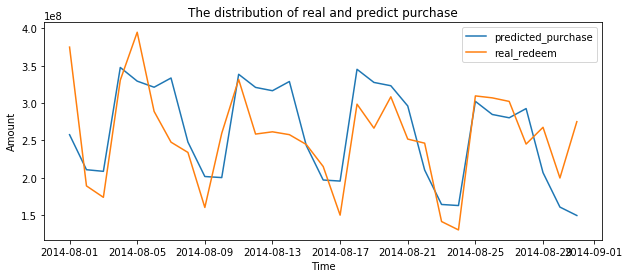

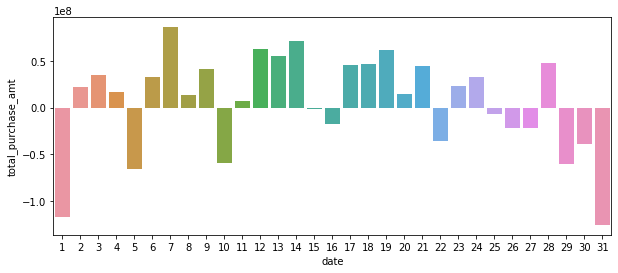

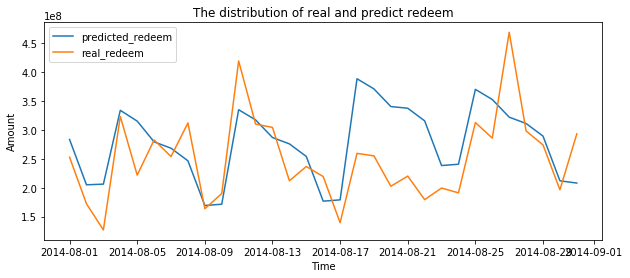

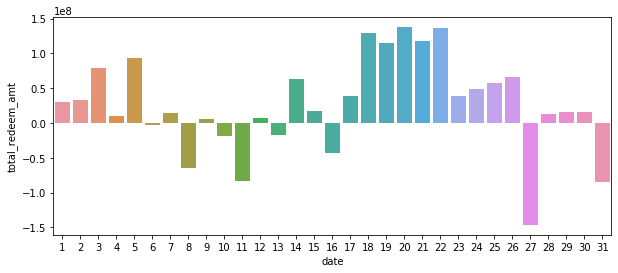

In [118]:
trainset, testset = split_data_underline(data)
visual(result_purchase_lr, result_redeem_lr, testset)

In [119]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_redeem_amt')

### 生成线上效果（线性）
可以看到28号很高（work in Sunday）

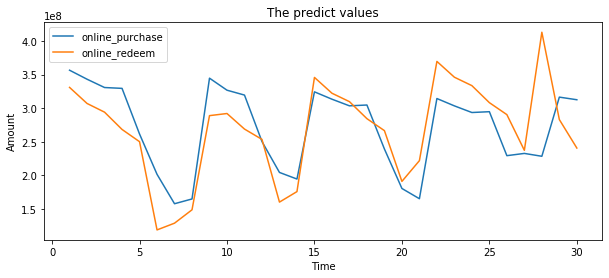

In [120]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

purchase feature

> 'dis_to_nowork', 'dis_to_work', 'dis_from_work', 'purchase_weekdayrate',
       'redeem_dayrate', 'weekday_onehot_5', 'weekday_onehot_6',
       'dis_from_nowork', 'is_holiday', 'weekday_onehot_1', 'weekday_onehot_2',
       'weekday_onehot_0', 'dis_from_middleofweek', 'dis_from_holiendday',
       'weekday_onehot_3', 'is_lastday_of_holiday', 'is_firstday_of_holiday',
       'weekday_onehot_4', 'is_worked_yestday', 'is_second_week',
       'is_third_week', 'dis_from_startofmonth', 'dis_from_holiday',
       'dis_to_nowork%%%%dis_from_purchase_peak', 'total_purchase_amt',
       'total_redeem_amt', 'date'

Redeem feature

>'is_work', 'dis_from_redeem_valley', 'purchase_weekdayrate',
       'redeem_dayrate', 'weekday_onehot_5', 'is_gonna_work_tomorrow',
       'is_holiday', 'dis_from_nowork', 'weekday_onehot_0', 'weekday_onehot_1',
       'is_firstday_of_holiday', 'weekday_onehot_2', 'is_lastday_of_holiday',
       'dis_from_holiday', 'is_work_on_sunday', 'is_firstday_of_work',
       'is_secday_of_month', 'dis_from_holiendday',
       'dis_from_redeem_valley%%%%dis_from_redeem_peak', 'total_purchase_amt',
       'total_redeem_amt', 'date'

In [121]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv(data_submit_path + '20190614_droped_nb6.csv',index=False,header=None)

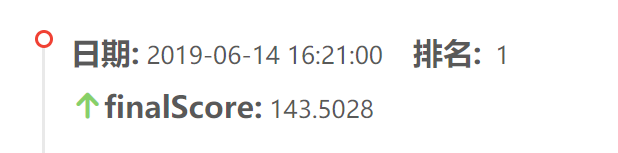

### 生成线上效果（MLP）

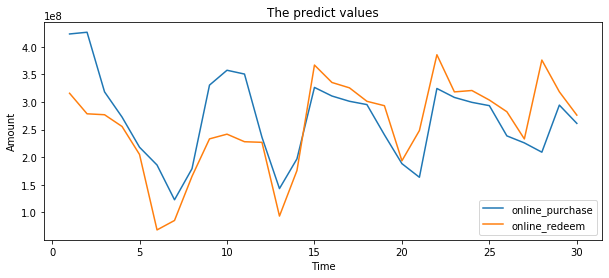

In [122]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            MLPRegressor(solver='lbfgs'),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          MLPRegressor(solver='lbfgs'),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [123]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv(data_submit_path + '20190614_droped_MLP_nb6.csv',index=False,header=None)

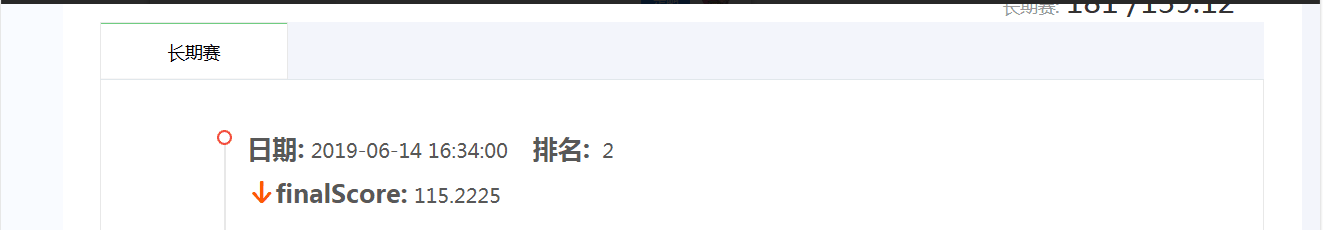

### 生成线上效果（Xgboost）

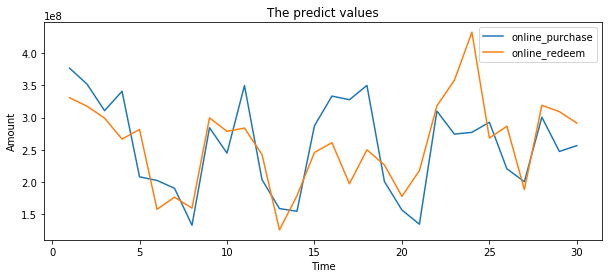

In [124]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            xgb.XGBRegressor(objective='reg:squarederror'),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          xgb.XGBRegressor(objective='reg:squarederror'),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [125]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv(data_submit_path + '20190615_droped_XGB_nb6.csv',index=False,header=None)

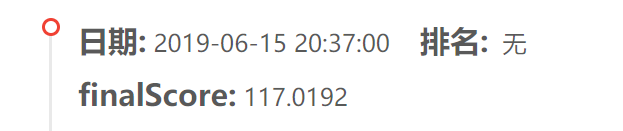

## 四、AIC模型平均

In [126]:
purchase_features, purchase_weight = multi_model(data_purchase, model=LinearRegression(), types = 'purchase')

In [127]:
redeem_features, redeem_weight = multi_model(data_redeem, model=LinearRegression(), types = 'redeem')

In [128]:
def eva_for_aic(data_purchase, purchase_features, purchase_weight):
    results = pd.DataFrame()
    for index, feature in enumerate(purchase_features):
        if results.empty:
            results = scale_df(multi_model_eva(data_purchase[['date'] + labels + feature], 'purchase'), 
                               eta = purchase_weight[index])
        else:
            results = add_two_df(results, multi_model_eva(data_purchase[['date'] + labels + feature], 'purchase')
                                 , left_a = 1,
                                 right_a = purchase_weight[index])
    return results

In [129]:
add_two_df(eva_for_aic(data_purchase, purchase_features, purchase_weight), 
           eva_for_aic(data_redeem, redeem_features, redeem_weight))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,194.887107,184.105350,191.926163,187.137417,195.898802,182.605827
1,2014-07-25,166.373602,168.026398,171.604524,166.743554,166.925155,167.913565
2,2014-07-18,165.618749,158.643465,164.658681,163.128224,164.604436,157.442157
3,2014-07-11,161.450795,166.512460,167.212367,167.261756,167.581184,162.904611
4,2014-07-04,144.339840,145.042276,146.902682,146.471703,152.498516,148.850193
5,2014-06-27,158.093265,163.205321,168.359142,165.339334,159.368465,164.774035
6,2014-06-20,158.092213,163.740772,168.951821,165.852281,168.303634,165.881584


## 五、针对残差建模

In [ ]:
data_purchase = pd.read_csv('Feature/residual_feature_purchase_0621.csv')
data_purchase['date'] = pd.to_datetime(data_purchase['date'])

In [ ]:
data_redeem = pd.read_csv('Feature/residual_feature_redeem_0621.csv')
data_redeem['date'] = pd.to_datetime(data_redeem['date'])

In [ ]:
base = pd.read_csv('Dataset/base.csv')

In [ ]:
def generate_residual_result(data, base, model=LinearRegression(), types = 'purchase', split_time = datetime.date(2014,8,1)):
    a_month = relativedelta(months=1)
    trainset = data[(datetime.date(2014,4,1) <= data['date']) & (data['date'] < split_time)]
    testset = data[(split_time <= data['date']) & (data['date'] < split_time + a_month)]
    feature = [x for x in data_purchase.columns 
               if x not in ['total_purchase_amt','total_redeem_amt','date']]
    model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
    result_purchase_rate = model.predict(testset[feature])
    
    base['date'] = pd.to_datetime(base['date'], format= "%Y%m%d")
    result_purchase_cycle = np.array(base[(base['date'] >= split_time)
                                          &(base['date'] < split_time + a_month)]['total_'+types+'_predicted_by_cycle'])
    result_purchase_residual =  result_purchase_rate * np.array(result_purchase_cycle)
    return result_purchase_residual

In [ ]:
def generate_evaluate_for_residual(model=LinearRegression()):
    result = []
    for i in [datetime.date(2014, 8, 1), datetime.date(2014, 7, 25), datetime.date(2014, 7, 18), datetime.date(2014, 7, 11), 
              datetime.date(2014, 7, 4), datetime.date(2014, 6, 27), datetime.date(2014, 6,20)]:
        result_purchase_residual = generate_residual_result(data_purchase, base, model=model, types='purchase', split_time = i)
        result_redeem_residual = generate_residual_result(data_purchase, base, model=model, types='redeem', split_time= i)
        a_month = relativedelta(months=1)
        testset = data[(data['date'] >= i) & (data['date'] < i + a_month)]
        real_purchase = testset['total_purchase_amt']
        real_redeem = testset['total_redeem_amt']
        result.append(total_AE(result_purchase_residual, result_redeem_residual, real_purchase, real_redeem))
    return pd.DataFrame(result)

In [ ]:
def multi_model_eva_for_residual():
    results = pd.DataFrame()
    for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
        if results.empty:
            results = draw_eva_table(generate_evaluate_for_residual(model)).rename(columns={0: repr(model).split('(')[0]})
        else:
            results = pd.merge(results, \
                               draw_eva_table(generate_evaluate_for_residual(model)).rename(columns={0: repr(model).split('(')[0]}))
    results = results[['interval'] + [x for x in results.columns if x != 'interval']]
    return results

In [ ]:
def generate_evaluate_for_cycle():
    result = []
    for i in [datetime.date(2014, 8, 1), datetime.date(2014, 7, 25), datetime.date(2014, 7, 18), datetime.date(2014, 7, 11), 
                  datetime.date(2014, 7, 4), datetime.date(2014, 6, 27), datetime.date(2014, 6,20)]:
        a_month = relativedelta(months=1)
        testset = base[(base['date'] >= i) & (base['date'] < i + a_month)].reset_index(drop=True)
        result_purchase_residual = testset['total_purchase_predicted_by_cycle']
        result_redeem_residual = testset['total_redeem_predicted_by_cycle']
        testset = data[(data['date'] >= i) & (data['date'] < i + a_month)].reset_index(drop=True)
        real_purchase = testset['total_purchase_amt']
        real_redeem = testset['total_redeem_amt']
        result.append(total_AE(result_purchase_residual, result_redeem_residual, real_purchase, real_redeem))
    return pd.DataFrame(result).rename(columns={0: 'PureTimeSeries'})

In [ ]:
pd.merge(multi_model_eva_for_residual(), draw_eva_table(generate_evaluate_for_cycle()))

### (1) 只使用周期因子在8月份的预测效果

In [ ]:
_, testset = split_data_underline(data)

In [ ]:
real_purchase = testset['total_purchase_amt']
real_redeem = testset['total_redeem_amt']

In [ ]:
result_purchase_cycle = np.array(base[(base['date'] >= datetime.date(2014,8,1))&(base['date'] < datetime.date(2014,9,1))]['total_purchase_predicted_by_cycle'])
result_redeem_cycle = np.array(base[(base['date'] >= datetime.date(2014,8,1))&(base['date'] < datetime.date(2014,9,1))]['total_redeem_predicted_by_cycle'])
total_AE(result_purchase_cycle, result_redeem_cycle, real_purchase, real_redeem)

In [ ]:
trainset, testset = split_data_underline(data)
visual(result_purchase_cycle, result_redeem_cycle, testset)

### (2) 只使用周期因子+预测残差在8月份的预测效果（比单纯用因子好）

In [ ]:
trainset_purchase, testset_purchase = split_data_underline(data_purchase)
result_purchase_rate = generate_under_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')

In [ ]:
trainset_redeem, testset_redeem = split_data_underline(data_redeem)
result_redeem_rate = generate_under_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')

In [ ]:
total_AE(result_purchase_rate * result_purchase_cycle, result_redeem_rate * result_redeem_cycle, real_purchase, real_redeem)

In [ ]:
trainset, testset = split_data_underline(data)
visual(result_purchase_rate * result_purchase_cycle, result_redeem_rate * result_redeem_cycle, testset)

### (3) 生成线上结果

In [ ]:
trainset_purchase, testset_purchase = split_data_online(data_purchase)
result_purchase_rate = generate_online_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')

In [ ]:
trainset_redeem, testset_redeem = split_data_online(data_redeem)
result_redeem_rate = generate_online_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')

In [ ]:
# 修正一下预测结果试试
result_purchase_rate = result_purchase_rate / np.mean(result_purchase_rate)
result_redeem_rate = result_redeem_rate / np.mean(result_redeem_rate)

In [ ]:
result_purchase_cycle = np.array(base[(base['date'] >= datetime.date(2014,9,1))&(base['date'] < datetime.date(2014,10,1))]['total_purchase_predicted_by_cycle'])
result_redeem_cycle = np.array(base[(base['date'] >= datetime.date(2014,9,1))&(base['date'] < datetime.date(2014,10,1))]['total_redeem_predicted_by_cycle'])

In [ ]:
result_purchase_residual = result_purchase_rate * result_purchase_cycle

In [ ]:
result_redeem_residual = result_redeem_rate * result_redeem_cycle

#### 月份周期因子线上结果（135）

In [ ]:
draw_result(result_purchase_cycle, result_redeem_cycle, testset_redeem)

#### 残差处理后结果

In [ ]:
draw_result(result_purchase_residual, result_redeem_residual, testset_redeem)

In [ ]:
normalize_upload_file(result_purchase_residual, result_redeem_residual, testset_redeem).to_csv('20190622_residual_liner.csv',index=False,header=None)

#### 仅用与修正节假日的结果

In [ ]:
result_score135 = pd.read_csv('Result/timeseries0606.csv',header=None)

In [ ]:
result_residual = normalize_upload_file(result_purchase_residual, result_redeem_residual, testset_redeem).reset_index(drop=True)

In [ ]:
result_residual['date'] = result_residual['date'].astype(int)

In [ ]:
days_need_to_change = [
    20140906,
    20140907,
    20140908,
    20140928
]

In [ ]:
for index,row in result_score135.iterrows():
    if row[0] in days_need_to_change:
        result_score135.loc[index, 1] =  result_residual.loc[index, 'total_purchase_amt']
        result_score135.loc[index, 2] =   result_residual.loc[index, 'total_redeem_amt']

In [ ]:
result_score135.to_csv('result135_fixed_by_residual_0621.csv',index=False,header=None)